# Characterization of Alzheimer's Disease through clustering of Medical notes

## Introduction

### Importing packages

In [971]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from gap_statistic import OptimalK

## Data Pre-processing

### Exploring the data

In [972]:
path = "data/EO_AD-CONSULT.csv"
df = pd.read_csv(path)
df

,person_id,birth_datetime,gender_source_value,race_source_value,ethnicity_source_value,note_title,note_text
0,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
1,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,FINDINGS OF PULMONARY EDEMA. ACUITY LEVEL: 2. ...
2,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
3,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
4,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,1. Moderate subcutaneous hematoma about the le...
...,...,...,...,...,...,...,...
26182,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,X-ray abdomen complete with chest Indication: ...
26183,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,CTA dissection protocol. Technique: Axial imag...
26184,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,CTA dissection protocol. Technique: Axial imag...
26185,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,Study: AP radiograph of the chest History: Wea...


### Calculating the age of each patient from their birth date

In [973]:
# Converting the "birth_datetime" column to a datetime format 
df["birth_datetime"] = pd.to_datetime(df["birth_datetime"], format='%Y-%m-%d')
# Calculating the age by substracting the current date with the date in the dataframe
df["age"] = (pd.Timestamp('now') - df["birth_datetime"]).astype('timedelta64[Y]')
# Converting age to integer
df["age"]  = pd.to_numeric(df["age"], downcast='integer')
# Dropping the birth_datetime (it's useless at this point) 
df = df.drop("birth_datetime", axis=1)
# Re-arranging the order of the columns
df = df[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'note_title', 'note_text']]
df

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value,note_title,note_text
0,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
1,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,FINDINGS OF PULMONARY EDEMA. ACUITY LEVEL: 2. ...
2,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
3,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
4,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,1. Moderate subcutaneous hematoma about the le...
...,...,...,...,...,...,...,...
26182,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,X-ray abdomen complete with chest Indication: ...
26183,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,CTA dissection protocol. Technique: Axial imag...
26184,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,CTA dissection protocol. Technique: Axial imag...
26185,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,Study: AP radiograph of the chest History: Wea...


#### Some statistics on the age of the patients

In [974]:
df['age'].describe()

count    26187.000000
mean        77.554741
std         11.470307
min         26.000000
25%         67.000000
50%         81.000000
75%         88.000000
max         99.000000
Name: age, dtype: float64

### Creating the corpus from medical notes 

#### Using the note_text column for raw data

In [975]:
corpus_raw = list(df["note_text"])

#### Removing words that don't contain much meaning from our notes

In [976]:
words_to_remove = ["evidence", "Read By", "images", "report", "concur", "findings", "agree", "seen", "residents", "resident", "Resident", "unspecified provider", "Released Date Time", "personally reviewed" ,"D.O", "MD", "M.D.", "Electronically Verified By", "NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]
# words_to_remove = ["NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]

# words_to_remove = words_to_remove + list(STOPWORDS)
corpus_clean = []
for item in corpus_raw:
    for word in words_to_remove:
        item = item.replace(word, '') 
    corpus_clean.append(item)

In [977]:
df['note_text'].iloc[989]

'IMPRESSION: No acute osseous abnormality. I personally reviewed the images and the residents findings and agree with the above. Read By - [**NAME**] D.O.  Electronically Verified By - [**NAME**] D.O.  Released Date Time - [**DATE**] 9:52 AM  Resident - [**NAME**]'

#### Taking each word from the cleaned corpus and making it lowercase

In [978]:
corpus = [word.lower() for word in corpus_clean]
corpus[989]

'impression: no acute osseous abnormality. i  the  and the   and  with the above.  -  .   -  .   -  9:52 am   - '

#### Adding the pre-processed version of the notes to the DataFrame

In [979]:
df["note_text"] = corpus
df

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value,note_title,note_text
0,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,no acute osseous abnormality of the right shou...
1,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,findings of pulmonary edema. acuity level: 2. ...
2,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,no acute osseous abnormality of the right shou...
3,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,no acute osseous abnormality of the right shou...
4,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,1. moderate subcutaneous hematoma about the le...
...,...,...,...,...,...,...,...
26182,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,x-ray abdomen complete with chest indication: ...
26183,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,cta dissection protocol. technique: axial of ...
26184,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,cta dissection protocol. technique: axial of ...
26185,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,study: ap radiograph of the chest history: wea...


## Creating Text embeddings

In [980]:
model = SentenceTransformer("../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT")

No sentence-transformers model found with name ../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at ../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

### Some model parameters

The Transformer itself has a max sequence length of 512 tokens and it does not lowercase the input. For the pooling operation we will produce a 768-dimensional sentence embedding. We do this using mean pooling 

In [981]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [982]:
embeddings = model.encode(corpus, show_progress_bar=True)

Batches:   0%|          | 0/819 [00:00<?, ?it/s]

In [983]:
embeddings

array([[-0.04270806, -0.2722384 ,  0.02541331, ...,  0.14533459,
        -0.0664463 , -0.11730304],
       [ 0.24206899, -0.12554152, -0.11126476, ...,  0.13504232,
        -0.07171036, -0.21101835],
       [-0.04270806, -0.2722384 ,  0.02541331, ...,  0.14533459,
        -0.0664463 , -0.11730304],
       ...,
       [ 0.14000909, -0.24060056,  0.01999374, ...,  0.20956802,
        -0.19258067, -0.10662035],
       [-0.02650105, -0.33855188, -0.09942739, ...,  0.29439577,
        -0.02508109, -0.12649913],
       [ 0.14000909, -0.24060056,  0.01999374, ...,  0.20956802,
        -0.19258067, -0.10662035]], dtype=float32)

In [984]:
embeddings.shape

(26187, 768)

From the last cell, we see that our embeddings are high-dimensional as they contain several featured (768). To handle this, we use dimensionallity reduction so that we can both visualize and cluster our embeddings.

## Finding the right k

Before performing k means clustering we need to find the exact number K that can optimize our number of cluster. To do so, we will use gap statistic

In [985]:
TOKENIZERS_PARALLELISM = False
optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalK(embeddings, n_refs=50, cluster_array=np.arange(1,10))
print(f"The correct number of clusters is:{num_clusters}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/envs/rapids/lib/python3.9/site-packages/gap_statistic/optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
/opt/conda/envs/rapids/lib/python3.9/site-packages/gap_statistic/optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
/opt/conda/envs/rapids/lib/python3.9/site-packages/gap_statistic/optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
/opt/conda/envs/rapids/lib/python3.9/site-packages/gap_statistic/optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
/opt/conda/envs/rapids/lib/python3.9

In [986]:
optimalK.gap_df

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,1.0,1.630707,274.764347,0.000188,1.189088e+06,1.200920e+06,-0.108530,1.201131e+06
1,2.0,1.739451,312.769516,0.000215,1.210339e+06,1.222383e+06,-0.072500,1.222544e+06
2,3.0,1.812205,367.457925,0.000253,1.226589e+06,1.238794e+06,-0.009623,1.238803e+06
3,4.0,1.822058,332.502727,0.000229,1.227440e+06,1.239653e+06,-0.147026,1.239964e+06
4,5.0,1.969301,314.996672,0.000217,1.258664e+06,1.271189e+06,-0.016781,1.271215e+06
5,6.0,1.986348,385.081567,0.000266,1.261269e+06,1.273819e+06,-0.033392,1.273876e+06
6,7.0,2.019961,320.031783,0.000221,1.267016e+06,1.279623e+06,-0.052223,1.279715e+06
7,8.0,2.072445,376.729857,0.000261,1.276228e+06,1.288928e+06,-0.031155,1.288977e+06
8,9.0,2.103814,309.391242,0.000214,1.281178e+06,1.293927e+06,NaN,NaN


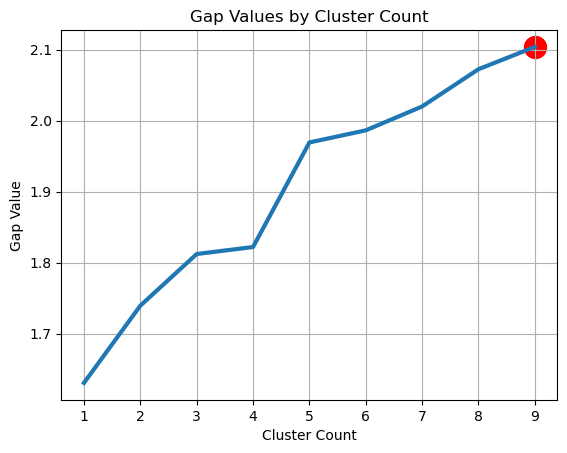

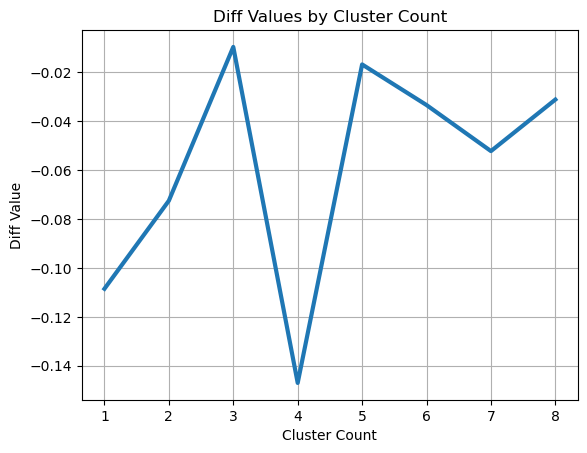

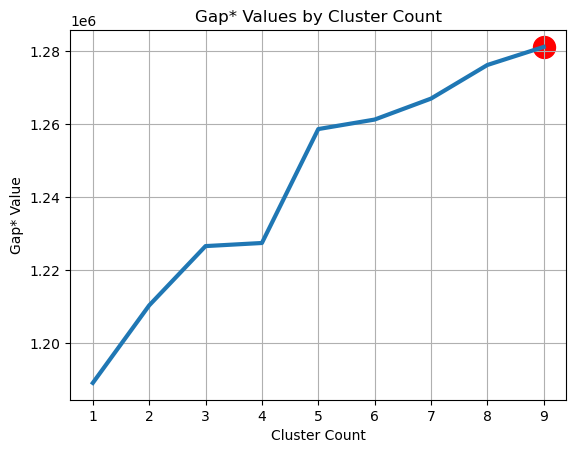

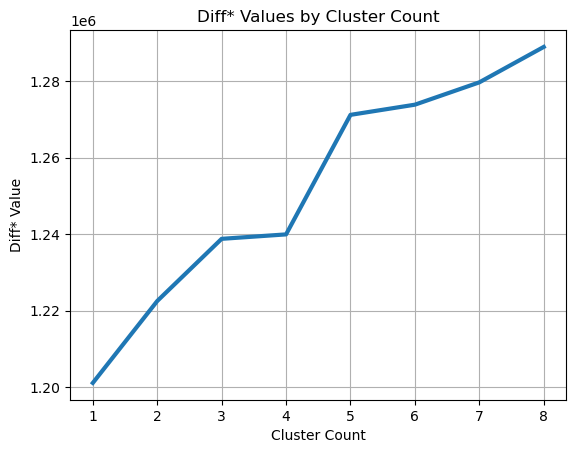

In [987]:
optimalK.plot_results()

In [988]:
# Create an empty dictionary to save the within cluster sum of square values
wcss = {} 
# Look through the number of clusters
for i in range(1,10):
  # Run kmeans model
  kmeans = KMeans(n_clusters=i, random_state=0).fit(embeddings)
  #Sum of squared distances of samples to their closest cluster center.
  wcss[i] = (kmeans.inertia_)
  # Print the within cluster sum of squares for each cluster number
  print(f'The within cluster sum of squares for {i} clusters is {wcss[i]}')

The within cluster sum of squares for 1 clusters is 289493.40625
The within cluster sum of squares for 2 clusters is 253244.625
The within cluster sum of squares for 3 clusters is 227661.171875
The within cluster sum of squares for 4 clusters is 214158.28125
The within cluster sum of squares for 5 clusters is 203111.359375
The within cluster sum of squares for 6 clusters is 193679.375
The within cluster sum of squares for 7 clusters is 186478.34375
The within cluster sum of squares for 8 clusters is 179646.25
The within cluster sum of squares for 9 clusters is 174230.671875


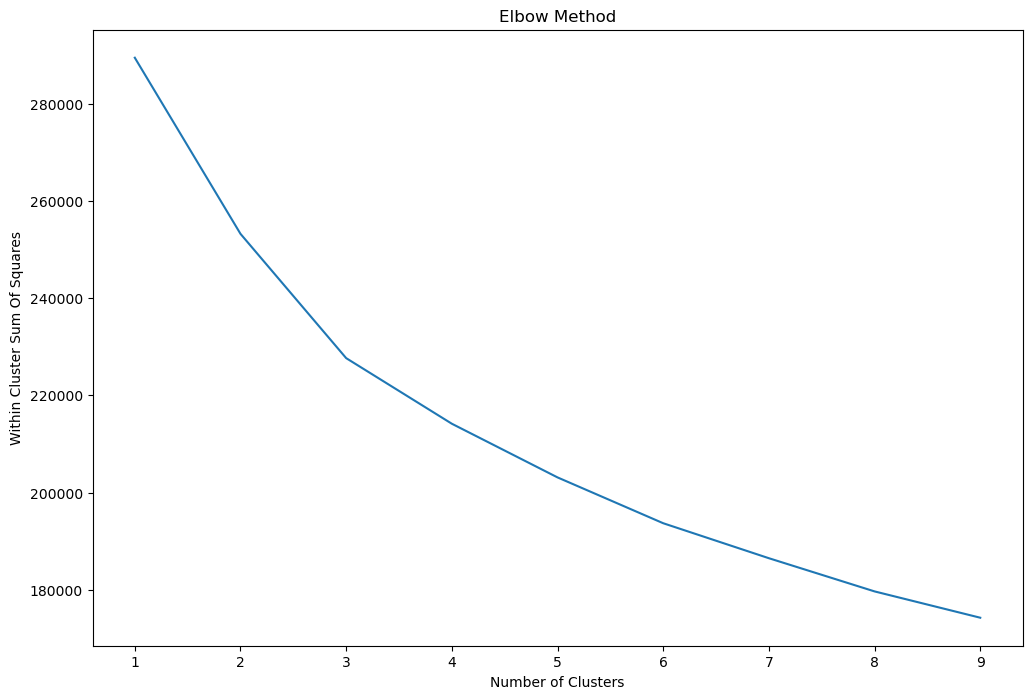

In [989]:
# Visualization
plt.figure(figsize=(12,8))
plt.plot(list(wcss.keys()),list(wcss.values()))
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')    
plt.ylabel('Within Cluster Sum Of Squares')
plt.show()

## Dimensionality Reduction

In [990]:
reducer = umap.UMAP(metric="cosine", n_neighbors=num_clusters, n_components=2)
umap_embedding = reducer.fit_transform(embeddings)
umap_embedding.shape

(26187, 2)

## Clustering with K-means

In [991]:
cluster = KMeans(n_clusters=num_clusters)
cluster.fit(umap_embedding)
cluster_assignment = cluster.labels_

In [992]:
print(f"Running K means with {num_clusters} clusters")

Running K means with 9 clusters


### Taking a look at the different categories

In [993]:
cluster_assignment

array([3, 4, 3, ..., 2, 7, 2], dtype=int32)

### Putting the notes with their clusters for better visualization

In [994]:
df_corpus = pd.DataFrame({"person_id": df["person_id"], "Corpus": corpus, "Cluster": cluster_assignment})
df_corpus

,person_id,Corpus,Cluster
0,271,no acute osseous abnormality of the right shou...,3
1,271,findings of pulmonary edema. acuity level: 2. ...,4
2,271,no acute osseous abnormality of the right shou...,3
3,271,no acute osseous abnormality of the right shou...,3
4,271,1. moderate subcutaneous hematoma about the le...,7
...,...,...,...
26182,258985,x-ray abdomen complete with chest indication: ...,8
26183,258985,cta dissection protocol. technique: axial of ...,2
26184,258985,cta dissection protocol. technique: axial of ...,2
26185,258985,study: ap radiograph of the chest history: wea...,7


## Data Visualization

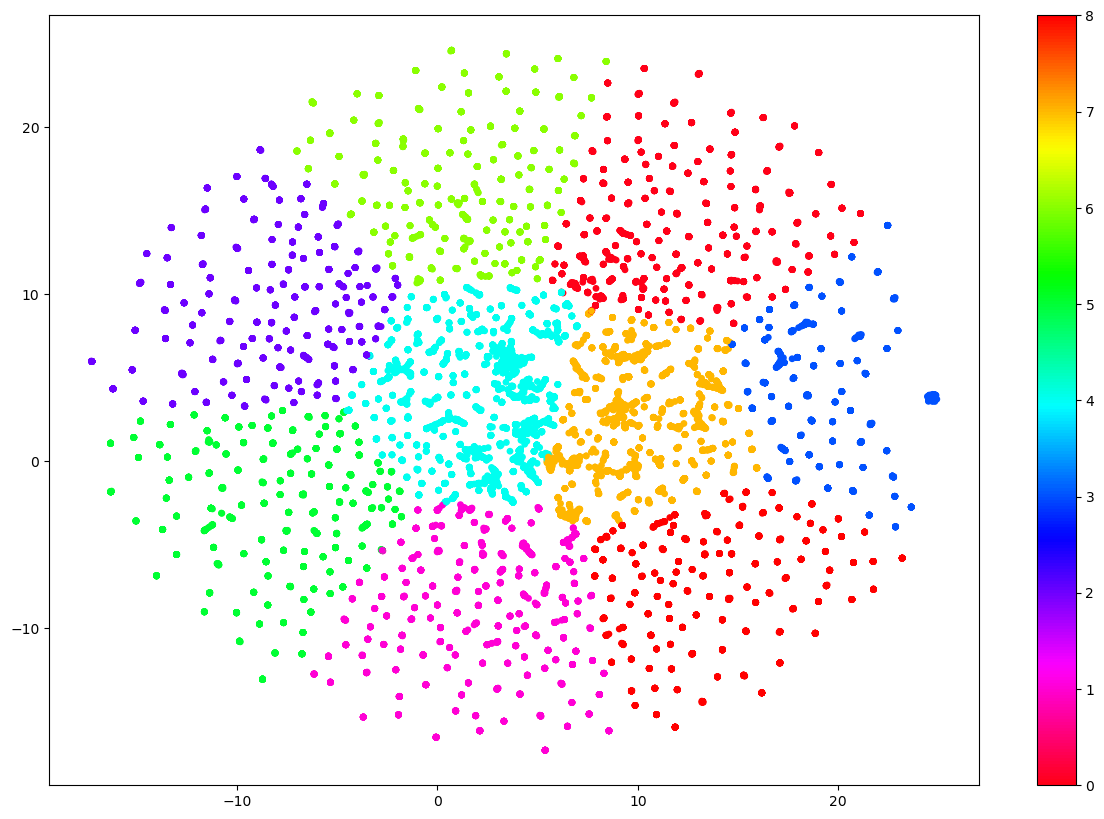

In [995]:
# Prepare data
result = pd.DataFrame(umap_embedding, columns=['x', 'y'])
result['labels'] = cluster_assignment

# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=15, cmap='hsv_r')
plt.colorbar()

In [996]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

def word_cloud(pred_df,label):
    wc = ' '.join([text for text in df_corpus['Corpus'][df_corpus['Cluster'] == label]])
    wordcloud = WordCloud(stopwords=STOPWORDS, width=3000, height=2000, background_color="white", max_words=1000).generate(wc)
    # set the word color to black
    wordcloud.recolor(color_func = black_color_func)# set the figsize
    plt.figure(figsize=[15,10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

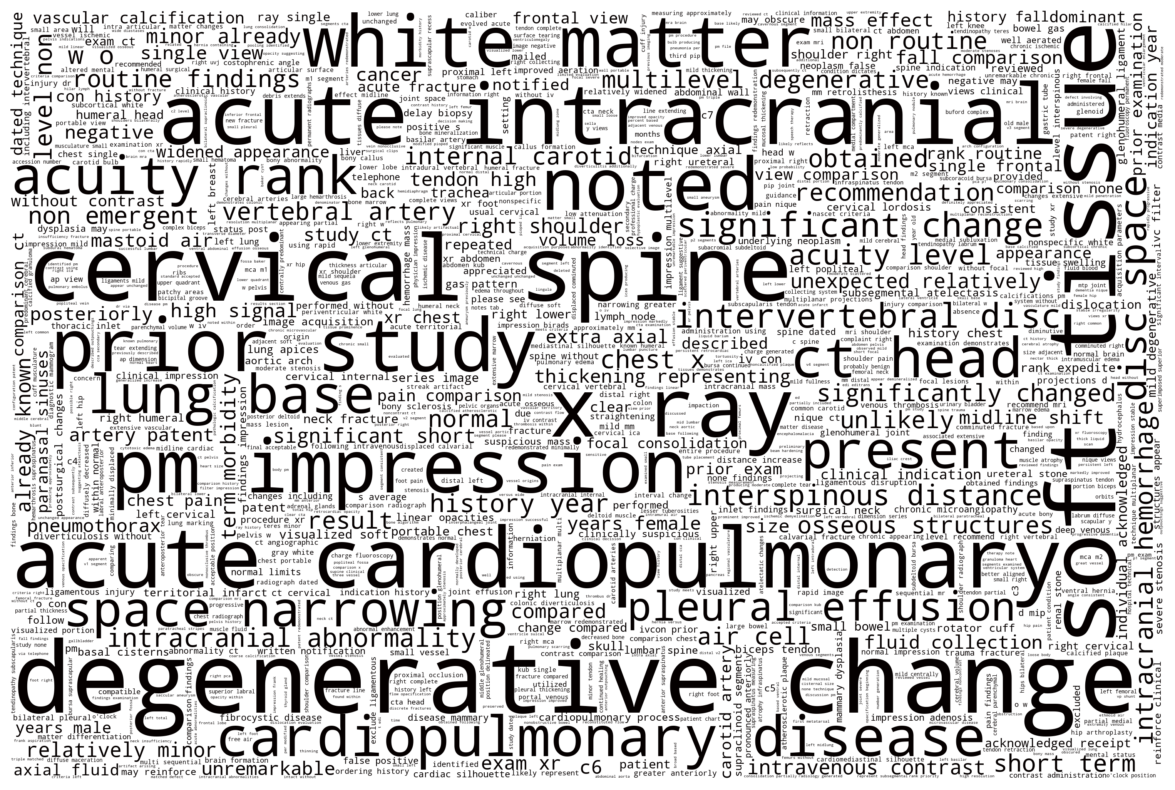

In [997]:
word_cloud(df_corpus, 0)

In [1000]:
docs_df = pd.DataFrame(corpus, columns=["Doc"])
docs_df['Topic'] = cluster_assignment
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [1001]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(corpus))

In [1002]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes

/opt/conda/envs/rapids/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
4,4,4193
7,7,3536
0,0,2963
1,1,2913
6,6,2690
5,5,2637
2,2,2613
8,8,2377
3,3,2265


In [1009]:
docs_per_topic['Doc'][:]

0    minimally displaced right greater trochanteric...
1    history: acute left ankle pain exam: xr foot l...
2    internal fixation of right intertrochanteric f...
3    no acute osseous abnormality of the right shou...
4    findings of pulmonary edema. acuity level: 2. ...
5    history: recent fall. patient presents with ne...
6    procedure: ct guided cholecystostomy tube plac...
7    1. moderate subcutaneous hematoma about the le...
8    impression: 1. no  of acute ischemia. 2. age-r...
Name: Doc, dtype: object

In [1003]:
top_n_words

{0: [('pm', 0.014027824954842116),
  ('impression', 0.013423012307507866),
  ('tendon', 0.011500553862769646),
  ('cervical', 0.01123326473469062),
  ('cardiopulmonary', 0.010267223797362014),
  ('intracranial', 0.008761563314866638),
  ('lung', 0.008501356026241576),
  ('interspinous', 0.00823878113561179),
  ('humeral', 0.008148473709555867),
  ('small', 0.008075823971149485),
  ('acute', 0.007912927507895772),
  ('head', 0.007887301765516793),
  ('level', 0.007813274805711284),
  ('fracture', 0.007650783652540538),
  ('shoulder', 0.007534205781905235),
  ('distance', 0.0075117519877827745),
  ('ray', 0.007467709741410148),
  ('clinical', 0.0074484153149017305),
  ('disease', 0.007424495575150351),
  ('intervertebral', 0.007354755683816801)],
 1: [('views', 0.010374225683823231),
  ('comparison', 0.009982760048207275),
  ('xr', 0.009804825723886683),
  ('view', 0.009683481324583163),
  ('fracture', 0.0095578497253548),
  ('joint', 0.009522263007631468),
  ('changes', 0.00939893995907

In [1004]:
top_n_words[1]

[('views', 0.010374225683823231),
 ('comparison', 0.009982760048207275),
 ('xr', 0.009804825723886683),
 ('view', 0.009683481324583163),
 ('fracture', 0.0095578497253548),
 ('joint', 0.009522263007631468),
 ('changes', 0.009398939959070192),
 ('knee', 0.00904334399821887),
 ('pain', 0.008720543439090372),
 ('chronic', 0.008675202830163776),
 ('years', 0.008576498354033738),
 ('degenerative', 0.00848490665794231),
 ('renal', 0.00828311272282049),
 ('ap', 0.008039416478902422),
 ('femur', 0.008035213223154772),
 ('pelvis', 0.007963051115452062),
 ('history', 0.007921487588897573),
 ('dislocation', 0.0079197434995063),
 ('forearm', 0.007917154387081356),
 ('findings', 0.007896622062614225)]

In [1005]:
top_n_words[0][:10]

[('pm', 0.014027824954842116),
 ('impression', 0.013423012307507866),
 ('tendon', 0.011500553862769646),
 ('cervical', 0.01123326473469062),
 ('cardiopulmonary', 0.010267223797362014),
 ('intracranial', 0.008761563314866638),
 ('lung', 0.008501356026241576),
 ('interspinous', 0.00823878113561179),
 ('humeral', 0.008148473709555867),
 ('small', 0.008075823971149485)]

In [1006]:
top_n_words[2][:10]

[('patent', 0.011494897322657788),
 ('artery', 0.01015402123355792),
 ('patient', 0.009515180424636236),
 ('fdg', 0.00898009005550873),
 ('breast', 0.00873309437042816),
 ('carotid', 0.008462473904028446),
 ('brain', 0.00803316290828149),
 ('biopsy', 0.007858312263223224),
 ('head', 0.007566305497572131),
 ('ct', 0.007471401132807324)]